# Assignment 6: Final Project

Jared Zymbaluk, Kory Clark, Sam Maxwell, Walker Brown

## Overview

For this assignment, we originally decided that we were going to create a Neural Network and apply Q-learning, a Reinforcement Learning algorithm (RL), in order to create a bot that would play Rocket League. This physics based video game simulates soccer using remote controlled cars instead of human players. The implementation was originally going to be based on the Q-net implementation provided during lectures. However, after some trial and error, we realized that this project was more intensive and time consuming than expected. With this in mind, we decided to veer away from the Rocket League project and instead came up with the idea to use Neural Network Progression to predict  what Landmass, Language, Religion, and Zone a flag belongs too based on certain attributes. We decided to take this a step further and thought it would be interesting to see if we could get the Neural Network to predict what each flag looked like based on R,G,B (red, green, blue) values being read in from .png files. 

We thought this would be a great oppurtunity to test the differences between Neural Networks that use the ```tanh()``` funtion versus those that use the Rectified Linear Unit (ReLU). In order to do this, we implemented a new class within ```neuralnetworksA2.py``` that extends the ```NeuralNetwork``` class from the previous assignment. Within the new extended class ```NeuralNetworkReLU```, we overwrote the ```activation``` and ```activationDerivative``` functions defined below:

```
def activation(self, weighted_sum):
    return np.tanh(weighted_sum)

def activationDerivative(self, activation_value):
    return 1 - activation_value * activation_value
```

**ReLU: **
The Rectified Linear Unit has become very popular in the last few years. It computes the function ```f(x)=max(0,x)```. In other words, the activation is simply thresholded at zero (see image above on the left). There are several pros and cons to using the ReLUs:

* (+) It was found to greatly accelerate (e.g. a factor of 6 in Krizhevsky et al.) the convergence of stochastic gradient descent compared to the sigmoid/tanh functions. It is argued that this is due to its linear, non-saturating form.
* (+) Compared to tanh/sigmoid neurons that involve expensive operations (exponentials, etc.), the ReLU can be implemented by simply thresholding a matrix of activations at zero.
* (-) Unfortunately, ReLU units can be fragile during training and can “die”. For example, a large gradient flowing through a ReLU neuron could cause the weights to update in such a way that the neuron will never activate on any datapoint again. If this happens, then the gradient flowing through the unit will forever be zero from that point on. That is, the ReLU units can irreversibly die during training since they can get knocked off the data manifold. For example, you may find that as much as 40% of your network can be “dead” (i.e. neurons that never activate across the entire training dataset) if the learning rate is set too high. With a proper setting of the learning rate this is less frequently an issue.

**source:**| http://cs231n.github.io/neural-networks-1/

In [25]:
import numpy as np
import pandas as pd
import neuralnetworksA2 as nn
import imp
from PIL import Image
import os
import numpy as np
import scipy.misc as smp

def readFiles(directory_str):
    array_of_pictures = []
    directory = os.fsencode(directory_str)
    
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".png"):
            img = Image.open(directory_str+filename)
            pixel_index = img.load()
            height, width = img.size
            data = np.array(img.getdata())
            picture = []
            for i in range(height):
                row = []
                for j in range(width):
                    row.append(pixel_index[i, j])
                picture.append(row)
            np_picture = np.array(picture)
        if  len(np_picture.shape) == 3 and np_picture.shape[2] == 3 :
            array_of_pictures.append(picture)
            
    return array_of_pictures

def standardizePictures(array_of_pictures):
    # Standardizing pictures so they all have the same dimension<><><>< NOT NEEDED (I think) <><><><><
    for picture in array_of_pictures:
        for row in picture:
            while len(row) < 367:   #Careful when using this line, when using other pictures
                row.append((0,0,0))
    array_of_pictures = [picture for picture in array_of_pictures if np.array(picture).shape == (550, 367, 3)]
    return array_of_pictures

def partition(trainDir,testDir):
    # Create arrays for training and testing pictures './flags-normal/train-data/'
    training_pictures = readFiles(trainDir)
    testing_pictures  = readFiles(testDir)
    
    # Standardize data (make sure all images are of the shame dimensions)
    training_pictures = standardizePictures(training_pictures)
    testing_pictures = standardizePictures(testing_pictures)
    
    return training_pictures,testing_pictures

def reshapeData(training_pictures):
    for picture in training_pictures[0:4]:
        # Split up picture data into X and T dataset
        X = np.array([row[int(0.2 * len(row)):] for row in picture])
        T = np.array([row[0:int(0.2 * len(row))] for row in picture])
        
        # Reshape X and T dataset to fit NeuralNetwork properly
        X_reshaped = X.reshape((X.shape[0], -1))
        T_reshaped= T.reshape((T.shape[0], -1))
        
        return X_reshaped, T_reshaped
    
def performRELU(X,hiddenLayerStructures,T,iterations):
    netc = nn.NeuralNetworkReLU(X.shape[1], hiddenLayerStructures, T.shape[1])
    netc.train(X, T, iterations)
    return netc

def performTanh(X,hiddenLayerStructures,T,iterations):
    netc = nn.NeuralNetwork(X.shape[1], hiddenLayerStructures, T.shape[1])
    netc.train(X, T, iterations)
    return netc
    
def displayPredictedImage(testing_pictures, netc):
    for picture in testing_pictures:  # To do a subset of all pictures, specify training_pictures[0:n]
    #     picture = np.array(picture).T    # If we wanted to transpose, doesn't look like it works
    #     print("Picture dimension" + str(np.array(picture).shape))
        # Split up picture
        X = np.array([row[int(0.2 * len(row)):] for row in picture])
        # print(len(X))
        T = np.array([row[0:int(0.2 * len(row))] for row in picture])
        # Reshape image dimensions back to tuples (Height, Width, 3)
        X_reshaped = X.reshape((X.shape[0], -1))
        T_reshaped= T.reshape((T.shape[0], -1)) 
        # Get predicted values
        predicted_values = netc.use(X_reshaped).reshape(T.shape)
        # Append predicted picture
        predict_pic = np.append(predicted_values, X, axis = 1)
        # Display image
        img = smp.toimage(predict_pic)       # Create a PIL image
        img.show()

In [26]:
training_pictures, testing_pictures = partition('./flags-normal/train-data/','./flags-normal/test-data/')

In [27]:
X,T = reshapeData(training_pictures)

In [28]:
ReLU_NN = performRELU(X,[1],T,100)

In [29]:
tanh_NN = performTanh(X,[1],T,100)

In [32]:
displayPredictedImage(testing_pictures,ReLU_NN)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:91: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


In [33]:
displayPredictedImage(testing_pictures,tanh_NN)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:91: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


### WALKER 
Pretty sure that ReLU is predicting the image better than the tanh() function. However, when it prints it seems to be faded in opacity or grayed out overall? Any ideas why that might happen? Anyways the data is looking good man. Good job pushing through it and figuring it out. 

In [3]:
print(np.array(training_pictures).shape)
print(np.array(testing_pictures).shape)

(65, 550, 367, 3)
(4, 550, 367, 3)


In [21]:
# import numpy as np
# import scipy.misc as smp
# imp.reload(nn)

# picture1 = picture
# # Create a 1024x1024x3 array of 8 bit unsigned integers
# data = np.zeros( (len(picture1[0]),len(picture1[0][0]),3), dtype=np.uint8 )

# for row in range(0,len(picture1[0])):
#     for col in range(0,len(picture1[0][0])):
#         data[row][col] = picture1[0][row][col]

# img = smp.toimage(data)       # Create a PIL image
# img.show()

# Neural Network Regression on Flag Data

## Data

#### Number of samples:

194

#### Source:

**Creators:**

Collected primarily from the "Collins Gem Guide to Flags": Collins Publishers (1986). 

**Donor:**

Richard S. Forsyth 

**Dataset**

[Data](https://archive.ics.uci.edu/ml/datasets/Flags)

#### Attribute Information:
* **name:**	Name of the country concerned 
* **landmass:**	1=N.America, 2=S.America, 3=Europe, 4=Africa, 4=Asia, 6=Oceania 
* **zone:**	Geographic quadrant, based on Greenwich and the Equator; 1=NE, 2=SE, 3=SW, 4=NW 
* **area:**	in thousands of square km 
* **population:**	in round millions 
* **language:** 1=English, 2=Spanish, 3=French, 4=German, 5=Slavic, 6=Other Indo-European, 7=Chinese, 8=Arabic, 9=Japanese/Turkish/Finnish/Magyar, 10=Others 
* **religion:** 0=Catholic, 1=Other Christian, 2=Muslim, 3=Buddhist, 4=Hindu, 5=Ethnic, 6=Marxist, 7=Others 
* **bars:** Number of vertical bars in the flag 
* **stripes:** Number of horizontal stripes in the flag 
* **colours:** Number of different colours in the flag 
* **red:** 0 if red absent, 1 if red present in the flag 
* **green:** same for green 
* **blue:** same for blue 
* **gold:** same for gold (also yellow) 
* **white:** same for white 
* **black:** same for black 
* **orange:** same for orange (also brown) 
* **mainhue:** predominant colour in the flag (tie-breaks decided by taking the topmost hue, if that fails then the most central hue, and if that fails the leftmost hue) 
* **circles:** Number of circles in the flag 
* **crosses:** Number of (upright) crosses 
* **saltires:** Number of diagonal crosses 
* **quarters:** Number of quartered sections 
* **sunstars:** Number of sun or star symbols 
* **crescent:** 1 if a crescent moon symbol present, else 0 
* **triangle:** 1 if any triangles present, 0 otherwise 
* **icon:** 1 if an inanimate image present (e.g., a boat), otherwise 0 
* **animate:** 1 if an animate image (e.g., an eagle, a tree, a human hand) present, 0 otherwise 
* **text:** 1 if any letters or writing on the flag (e.g., a motto or slogan), 0 otherwise 
* **topleft:** colour in the top-left corner (moving right to decide tie-breaks) 
* **botright:** Colour in the bottom-left corner (moving left to decide tie-breaks)

#### Input and Output Values

| Input Variables| Output Variables|
| -------------- | --------------  |
| area           | landmass        |
| population     | language        |
| bars           | religion        |
| stripes        | zone            |
| colors         |                 |
| red            |                 |
| green          |                 |
| blue           |                 |
| gold           |                 |
| white          |                 |
| black          |                 |
| orange         |                 |
| mainhue        |                 |
| circles        |                 |
| crosses        |                 |
| saltires       |                 |
| quarters       |                 |
| sunstars       |                 |
| crescent       |                 |
| triangle       |                 |
| icon           |                 |
| animate        |                 |
| text           |                 |
| topleft        |                 |
| botright       |                 |

#### Data Set Information:

This data file contains details of various nations and their flags. In this file the fields are separated by spaces (not commas). With this data you can try things like predicting the religion of a country from its size and the colours in its flag. 

10 attributes are numeric-valued. The remainder are either Boolean- or nominal-valued.

##### Works Cited
Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

In [50]:
import numpy as np
np.set_printoptions(threshold=np.nan)
import matplotlib.pyplot as plt
import neuralnetworks as nn
%matplotlib inline

In [51]:
Xnames =  ['bars','stripes','colors','red','green','blue','gold','white','black','orange','circles','crosses','saltires','quarters','sunstars','cresent','triangle','icon','animate','text']
Tnames = ['landmass','zone','language','religion']

X1 = np.loadtxt('Flag.csv', delimiter=',',skiprows=1,usecols=(range(7,17)),dtype=int)
X2 = np.loadtxt('Flag.csv', delimiter=',',skiprows=1,usecols=(range(18,28)),dtype=int)
X = np.concatenate((X1, X2), axis=1)

T1 = np.loadtxt('Flag.csv', delimiter=',',skiprows=1,usecols=(range(1,3)),dtype=int)
T2 = np.loadtxt('Flag.csv', delimiter=',',skiprows=1,usecols=(range(5,7)),dtype=int)
T = np.concatenate((T1, T2), axis=1)

In [52]:
X.shape,T.shape

((194, 20), (194, 4))

In [64]:
nnet = nn.NeuralNetwork(X.shape[1], [10], T.shape[1])
nnet.train(X, T, 100, verbose=True)
nnet

SCG: Iteration 10 fValue Eval 0.423960689067 Scale 0.032768
SCG: Iteration 20 fValue Eval 0.333528305541 Scale 6.4e-05
SCG: Iteration 30 fValue Eval 0.254225638441 Scale 6.25e-08
SCG: Iteration 40 fValue Eval 0.221878732941 Scale 6.103515625e-11
SCG: Iteration 50 fValue Eval 0.200167877622 Scale 5.960464477539062e-14
SCG: Iteration 60 fValue Eval 0.186588369334 Scale 1e-15
SCG: Iteration 70 fValue Eval 0.179018787886 Scale 1e-15
SCG: Iteration 80 fValue Eval 0.173139864532 Scale 1e-15
SCG: Iteration 90 fValue Eval 0.168137026795 Scale 1e-15
SCG: Iteration 100 fValue Eval 0.164171154353 Scale 1e-15


NeuralNetwork(20, [10], 4)
   Network was trained for 101 iterations that took 0.0591 seconds. Final error is 0.40518039729631766.

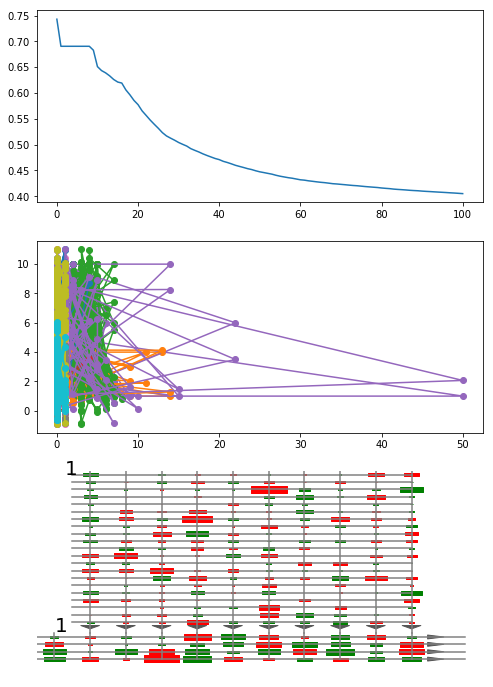

In [65]:
plt.figure(figsize=(8, 12))
plt.subplot(3, 1, 1)
plt.plot(nnet.getErrors())

plt.subplot(3, 1, 2)
plt.plot(X, T, 'o-', label='Actual')
plt.plot(X, nnet.use(X), 'o-', label='Predicted')

plt.subplot(3, 1, 3)
nnet.draw()

In [66]:
nnet = nn2.NeuralNetwork(X.shape[1], [10], T.shape[1])

In [67]:
nnet.train(X, T, 100, verbose=True)
nnet

SCG: Iteration 10 fValue Eval 0.357113127008 Scale 7.8125e-09
SCG: Iteration 20 fValue Eval 0.249680427931 Scale 7.62939453125e-12
SCG: Iteration 30 fValue Eval 0.208847739817 Scale 7.450580596923828e-15
SCG: Iteration 40 fValue Eval 0.195597013469 Scale 1e-15
SCG: Iteration 50 fValue Eval 0.188145613659 Scale 1e-15
SCG: Iteration 60 fValue Eval 0.182408019585 Scale 1e-15
SCG: Iteration 70 fValue Eval 0.178078302204 Scale 1e-15
SCG: Iteration 80 fValue Eval 0.174635004357 Scale 1e-15
SCG: Iteration 90 fValue Eval 0.171422172012 Scale 1e-15
SCG: Iteration 100 fValue Eval 0.168322510085 Scale 1e-15


NeuralNetwork(20, [10], 4)
   Network was trained for 101 iterations that took 0.0661 seconds. Final error is 0.41027126402535474.

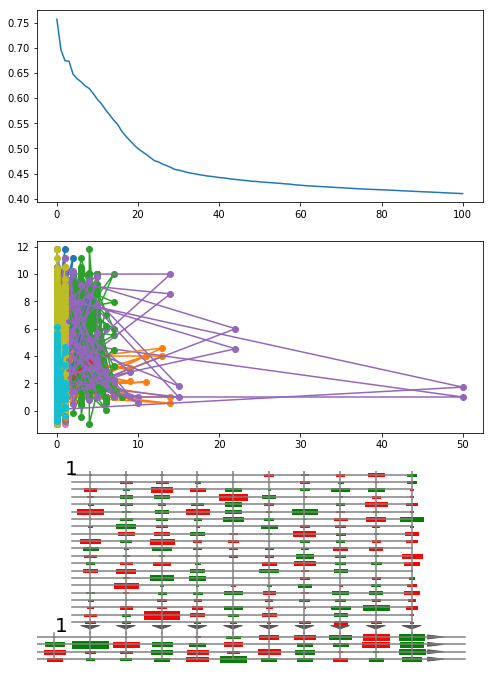

In [68]:
plt.figure(figsize=(8, 12))
plt.subplot(3, 1, 1)
plt.plot(nnet.getErrors())

plt.subplot(3, 1, 2)
plt.plot(X, T, 'o-', label='Actual')
plt.plot(X, nnet.use(X), 'o-', label='Predicted')

plt.subplot(3, 1, 3)
nnet.draw()

In [69]:
nRows = X.shape[0]
rows = np.arange(nRows)
np.random.shuffle(rows)
nTrain = int(nRows * 0.8)
trainRows = rows[:nTrain]
testRows = rows[nTrain:]
Xtrain, Ttrain = X[trainRows, :], T[trainRows, :]
Xtest, Ttest = X[testRows, :], T[testRows, :]

In [70]:
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((155, 20), (155, 4), (39, 20), (39, 4))

In [71]:
def rmse(A, B):
    return np.sqrt(np.mean((A - B)**2))

hiddens = [0, [1], [1, 1], [1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1, 1], [5], [5, 5], [5, 5, 5], [5, 5, 5, 5], [5, 5, 5, 5, 5], [10], [10, 10], [10, 10, 10], [10, 10, 10, 10], [10, 10, 10, 10, 10], [20], [20, 20], [20, 20, 20], [20, 20, 20, 20], [20, 20, 20, 20, 20], [50], [50, 50], [50, 50, 50], [50, 50, 50, 50], [50, 50, 50, 50, 50]]
                       0         1         2
0                      0  1.982318  2.282954
1                    [1]  1.953024  2.136595
2                 [1, 1]  1.887304  2.070806
3              [1, 1, 1]  1.953002  2.138602
4           [1, 1, 1, 1]  2.018907  1.951122
5        [1, 1, 1, 1, 1]  1.979429  2.355751
6                    [5]  1.481059  2.781735
7                 [5, 5]  1.419532  2.750121
8              [5, 5, 5]  1.194751  2.872533
9           [5, 5, 5, 5]  1.172758  2.901617
10       [5, 5, 5, 5, 5]  1.335654  2.746294
11                  [10]  1.121924  3.609822
12              [10, 10]  0.800428  3.356705
13          [10, 10, 10]  0.695686  

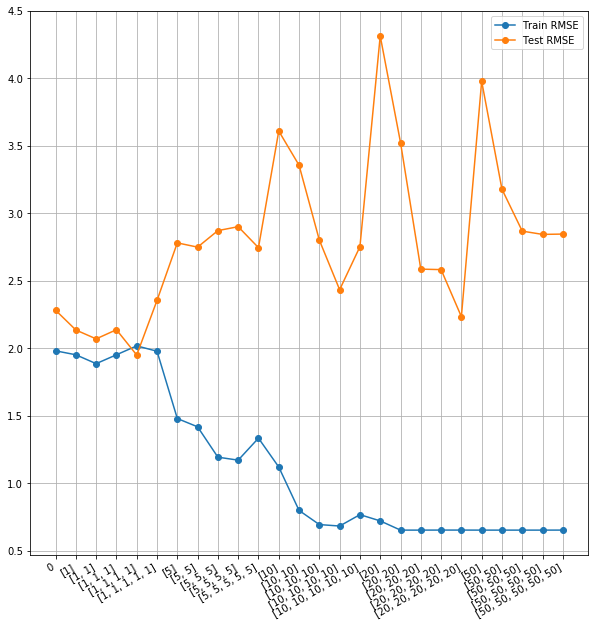

In [72]:
import pandas as pd
errors = []
hiddens = [0] + [[nu] * nl for nu in [1, 5, 10, 20, 50] for nl in [1, 2, 3, 4, 5]]
print('hiddens =', hiddens)
for hids in hiddens: 
    nnet = nn2.NeuralNetwork(Xtrain.shape[1], hids, Ttrain.shape[1])
    nnet.train(Xtrain, Ttrain, 500)
    errors.append([hids, rmse(Ttrain, nnet.use(Xtrain)), rmse(Ttest, nnet.use(Xtest))])
errors = pd.DataFrame(errors)
print(errors)

plt.figure(figsize=(10, 10))
plt.plot(errors.values[:, 1:], 'o-')
plt.legend(('Train RMSE', 'Test RMSE'))
plt.xticks(range(errors.shape[0]), hiddens, rotation=30, horizontalalignment='right')
plt.grid(True)

[10, 20, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
                   0         1         2
0   [50, 50, 50, 50]  1.969648  2.183285
1   [50, 50, 50, 50]  1.655566  2.298404
2   [50, 50, 50, 50]  1.394341  2.515923
3   [50, 50, 50, 50]  0.703482  2.689033
4   [50, 50, 50, 50]  0.656133  2.790038
5   [50, 50, 50, 50]  0.658128  2.876846
6   [50, 50, 50, 50]  0.655507  3.087120
7   [50, 50, 50, 50]  0.654776  2.787008
8   [50, 50, 50, 50]  0.654617  2.776726
9   [50, 50, 50, 50]  0.654614  2.823397
10  [50, 50, 50, 50]  0.654606  2.548175
11  [50, 50, 50, 50]  0.654601  2.719358


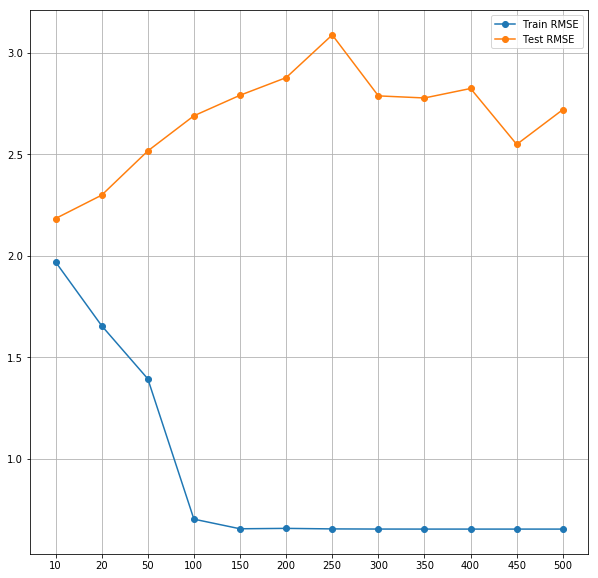

In [73]:
nIterationsList=[10, 20, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
errors = []
for hids in nIterationsList: 
    nnet = nn2.NeuralNetwork(Xtrain.shape[1], [50,50,50,50], Ttrain.shape[1])
    nnet.train(Xtrain, Ttrain, hids)
    errors.append([[50,50,50,50], rmse(Ttrain, nnet.use(Xtrain)), rmse(Ttest, nnet.use(Xtest))])
errors = pd.DataFrame(errors)



print(nIterationsList)
print(errors)
plt.figure(figsize=(10, 10))
plt.plot(errors.values[:, 1:], 'o-')
plt.legend(('Train RMSE', 'Test RMSE'))
plt.xticks(range(errors.shape[0]), nIterationsList) # , rotation=30, horizontalalignment='right')
plt.grid(True)